In [1]:
pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 34.8 MB/s eta 0:00:00


data length: 422784
filter length: 2
max levels: 18
Sampling Rate: 44100
Max Levels Used in Decomposition: 18


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 18 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Level 0: Number of coefficients = 422784
Level 1: Number of coefficients = 422784
Level 2: Number of coefficients = 422784
Level 3: Number of coefficients = 422784
Level 4: Number of coefficients = 422784
Level 5: Number of coefficients = 422784
Level 6: Number of coefficients = 422784
Level 7: Number of coefficients = 422784
Level 8: Number of coefficients = 422784
Level 9: Number of coefficients = 422784
Level 10: Number of coefficients = 422784
Level 11: Number of coefficients = 422784
Level 12: Number of coefficients = 422784
Level 13: Number of coefficients = 422784
Level 14: Number of coefficients = 422784
Level 15: Number of coefficients = 422784
Level 16: Number of coefficients = 422784
Level 17: Number of coefficients = 422784
Level 18: Number of coefficients = 422784
Number of thresholded coefficients: 291587


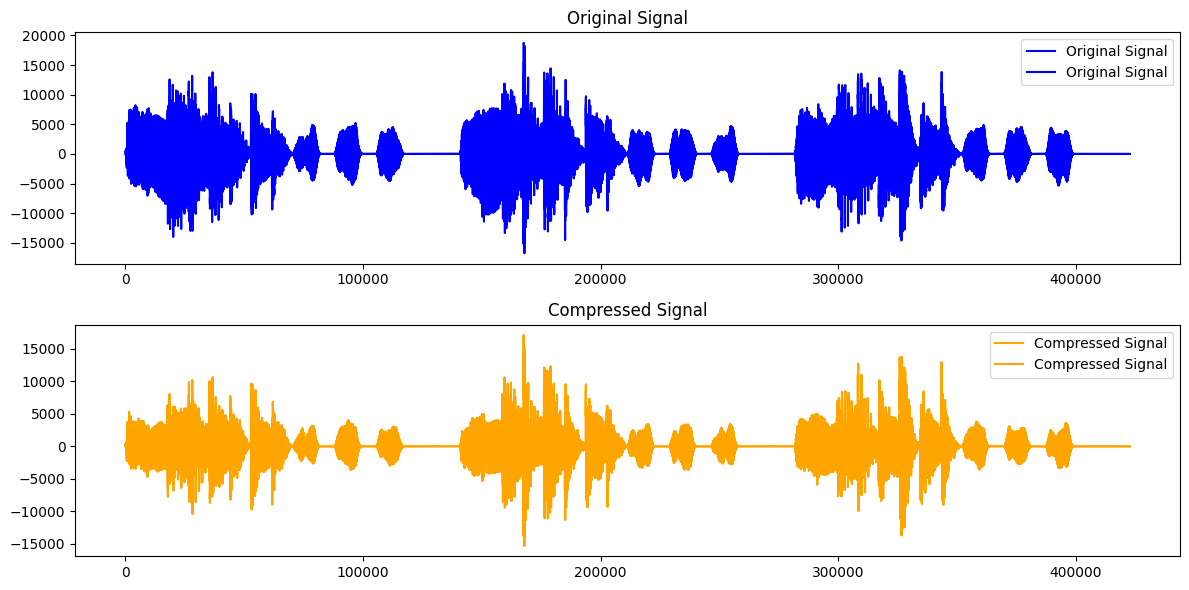

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Compression Ratio: 1.45
Signal-to-Noise Ratio (SNR): 22.10 dB


In [2]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write, read
from google.colab import files

# Function to read a WAV file
def read_wav(file_path):
    sample_rate, data = read(file_path)
    return data, sample_rate

# Function to write a WAV file with reduced sampling rate
def write_reduced_wav(file_path, data, original_sample_rate, target_sample_rate):
    factor = original_sample_rate // target_sample_rate
    data_downsampled = data[::factor]
    data_downsampled = data_downsampled[:len(data)//factor]
    max_val = np.max(np.abs(data_downsampled))
    data_normalized = ((data_downsampled / max_val) * 32767).astype(np.int16)  # Convert to int16
    write(file_path, target_sample_rate, data_normalized)

# Function for wavelet compression
def wavelet_compression(audio_signal, wavelet='db1', threshold_factor=0.005, max_levels=None):
    coeffs = pywt.wavedec(audio_signal, wavelet, level=max_levels)
    threshold = threshold_factor * np.max(np.abs(coeffs[0]))
    coeffs_thresholded = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    compressed_signal = pywt.waverec(coeffs_thresholded, wavelet)
    compressed_signal = compressed_signal[:len(audio_signal)]
    return compressed_signal, coeffs_thresholded

# Function to calculate compression ratio and SNR
def calculate_metrics(original, compressed, coeffs):
    length = min(len(original), len(compressed))
    original = original[:length]
    compressed = compressed[:length]
    original_size = len(original)
    compressed_size = sum([np.count_nonzero(c) for c in coeffs])
    compression_ratio = original_size / compressed_size
    mse = np.mean((original - compressed) ** 2)
    snr = 10 * np.log10(np.sum(original**2) / mse) if mse != 0 else float('inf')
    return compression_ratio, snr

# Function to calculate maximum decomposition levels
def calculate_max_levels(data, wavelet):
    data_len = len(data)
    filter_len = pywt.Wavelet(wavelet).dec_len
    max_levels = pywt.dwt_max_level(data_len, filter_len)
    print(f"data length: {data_len}")
    print(f"filter length: {filter_len}")
    print(f"max levels: {max_levels}")
    return max_levels

# File name of your uploaded audio
file_name = "sample.wav"

# File processing
original_signal, sample_rate = read_wav(file_name)

# Determine max levels of decomposition
wavelet = 'db1'  # Specify the wavelet type
threshold_factor = 0.005  # Threshold factor
max_levels = calculate_max_levels(original_signal, wavelet)
print(f"Sampling Rate: {sample_rate}")
print(f"Max Levels Used in Decomposition: {max_levels}")

# Compression
compressed_signal, coeffs_thresholded = wavelet_compression(original_signal, wavelet, threshold_factor, max_levels)

# Metrics
compression_ratio, snr = calculate_metrics(original_signal, compressed_signal, coeffs_thresholded)

# Count coefficients at each level
for i, coeff in enumerate(coeffs_thresholded):
    print(f"Level {i}: Number of coefficients = {len(coeff)}")

# Count total thresholded coefficients
thresholded_coeffs = sum([np.count_nonzero(c) for c in coeffs_thresholded])
print(f"Number of thresholded coefficients: {thresholded_coeffs}")

# Visualization
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(original_signal, label='Original Signal', color='blue')
plt.title("Original Signal")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(compressed_signal, label='Compressed Signal', color='orange')
plt.title("Compressed Signal")
plt.legend()
plt.tight_layout()
plt.show()

# Output compressed audio with reduced sampling rate
output_file = "compressed_audio_fixed_duration.wav"
target_sample_rate = 22050  # Use a higher sampling rate for better quality
write_reduced_wav(output_file, compressed_signal, sample_rate, target_sample_rate)

# Download compressed WAV
files.download(output_file)

# Performance Metrics
print(f"Compression Ratio: {compression_ratio:.2f}")
print(f"Signal-to-Noise Ratio (SNR): {snr:.2f} dB")
